<a href="https://colab.research.google.com/github/kgaero/Diffusion/blob/main/Diffusion_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: A Conditional Generative Model for Images
Welcome to lab 3! In the previous lab, we studied *unconditional* generation, for toy, two-dimensional data distributions. In this lab, we will study *conditional* generation on *images* from the MNIST dataset of handwritten digits. Each such MNIST image is not two dimensions but $32\times 32 = 1024$ dimensions! The nature of our new, more challenging setting will require us to take special care:
1. To tackle *conditional* generation, we will employ *classifier-free guidance* (CFG) (see Part 2.1).
2. To parameterize our learned vector field for high-dimensional image-valued data, a simple MLP will not suffice. Instead, we will adopt the *diffusion transformer* architecture (see part 3).

If you find any mistakes, or have any other feedback, please feel free to email us at `ezraerives@gmail.com`, `phold@mit.edu`, and `ronsh@mit.edu`. Enjoy!

In [ ]:
import os
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math
import uuid
import random

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.nn as nn
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from einops import rearrange
from einops.layers.torch import Rearrange

### Part 0: Recycling Components from Previous Labs
In this section, we'll re-import previous components from labs one and two. In doing so, we'll make some important updates. First, let's revisit our `Sampleable` class from labs one and two. Below, we have named it `OldSampleable`.

In [ ]:
class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """
    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: b d
        """
        pass

As we will see shortly, a dataset like MNIST contains both images (in this case handwritten digits), as well as class labels (a value from 0-9 indicating). We will therefore generalize `Sampleable` to `LabeledSampleable` to accommodate these labels as well. Whereas the old, `Sampleable.sample` method returned only `samples: torch.Tensor`, `LabeledSampleable.sample` will return both `samples: torch.Tensor` *and* `labels: Optional[torch.Tensor]`. In this way, we are formally realizing every such `Sampleable` instance as sampling from a *joint distribution* over data and labels. We implement our new `LabeledSampleable` below.

In [ ]:
class LabeledSampleable(ABC):
    """
    Distribution which can be sampled from
    """
    @abstractmethod
    def sample(self, num_samples: int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: b d
            - labels: b
        """
        pass

For certain distributions, such as a Gaussian, it doesn't really make sense to think about labels. For this reason, we'll choose to implement our Gaussian class as a simple Sampleable. Note, again, that our "objectification" of a simple Gaussian is pedantic, and is done for pedagogical purposes as well as to emphasize distributions as first class objects within our mental model. In the wild, it is commen, and practical, to simple use e.g., the library function `torch.randn`/`torch.randn_like`.

In [ ]:
class IsotropicGaussian(nn.Module, Sampleable):
    """
    Sampleable wrapper around torch.randn
    """
    def __init__(self, shape: List[int], std: float = 1.0):
        """
        shape: shape of sampled data
        """
        super().__init__()
        self.shape = shape
        self.std = std
        self.dummy = nn.Buffer(torch.zeros(1)) # Will automatically be moved when self.to(...) is called...

    def sample(self, num_samples) -> torch.Tensor:
        return self.std * torch.randn(num_samples, *self.shape).to(self.dummy.device)

We'll also go ahead and implement a *Gaussian mixture* (GMM), as in the earlier labs, for which labels emerge naturally from the constituent mixture component. The GMM will allow us to sanity check our conditional training and inference implementations before we move on to images.

In [ ]:
class GMM(nn.Module, LabeledSampleable):
  def __init__(self, means: torch.Tensor, covariances: torch.Tensor, weights: torch.Tensor):
    super().__init__()
    self.means = nn.Buffer(means)
    self.covariances = nn.Buffer(covariances)
    self.weights = nn.Buffer(weights)

  def sample(self, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Args:
      - num_samples: the desired number of samples
    Returns:
      - samples: b n
      - labels: b
    """
    # Choose the amount of each mode
    # Perform multinomial sampling on CPU to avoid device-side assert errors
    labels = torch.multinomial(self.weights.cpu(), num_samples=num_samples, replacement=True).to(self.means.device)

    # Sample from each mode
    samples = torch.zeros(num_samples, self.means.shape[1]).to(self.means.device)
    for idx in range(len(self.means)):
      samples[labels == idx] = torch.randn_like(samples[labels == idx]) * self.covariances[idx] + self.means[idx]

    return samples, labels

Next, we make two updates in adding `ConditionalProbabilityPath` (and `GaussianConditionalProbabilityPath`):
1. We adjust to handle the addition of labels to `LabeledSampleable`. Recall earlier that our called our conditioning variable `z` with $z \sim p_{\text{data}}(z)$. Now, we sample both `z`, as well as a label `y`, with $(z,y) \sim p_{\text{data}}(z,y)$.
2. We ensure that the logic is compatible with shapes of arbitrary size, denoting this as `b ...`. Depending on the situation, this could refer to `b d` (one feature per batch element), or `b c h w` (batch, channels, height, width), when working with images.

In [ ]:
class ConditionalProbabilityPath(nn.Module, ABC):
    """
    Abstract base class for conditional probability paths
    """
    def __init__(self, p_simple: Sampleable, p_data: LabeledSampleable):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the marginal distribution p_t(x) = p_t(x|z) p(z)
        Args:
            - t: b
        Returns:
            - x: samples from p_t(x), b ... (i.e.,. `b d`, `b c h w`, etc.)
        """
        num_samples = t.shape[0]
        # Sample conditioning variable z ~ p(z)
        z, _ = self.sample_conditioning_variable(num_samples) # (b ...)
        # Sample conditional probability path x ~ p_t(x|z)
        x = self.sample_conditional_path(z, t) # (b ...)
        return x

    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Samples the conditioning variable z and label y
        Args:
            - num_samples: the number of samples
        Returns:
            - z: b ...
            - y: b
        """
        pass

    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable b ...
            - t: time b
        Returns:
            - x: samples from p_t(x|z), b ...
        """
        pass

    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: b ...
            - z: b ...
            - t: b
        Returns:
            - conditional_vector_field: conditional vector field b c h w
        """
        pass

    @abstractmethod
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: b ...
            - z: b ...
            - t: b
        Returns:
            - score: b ...
        """
        pass

Finally, we add back in `GaussianConditionalProbabilityPath`, along with `LinearAlpha` and `LinearBeta`, defined similarly to the previous lab.

In [ ]:
class Alpha(ABC):
    def __init__(self):
        # Check alpha_t(0) = 0
        assert torch.allclose(
            self(torch.zeros(1,)), torch.zeros(1,)
        )
        # Check alpha_1 = 1
        assert torch.allclose(
            self(torch.ones(1,)), torch.ones(1,)
        )

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 0.0, self(1.0) = 1.0.
        Args:
            - t: b
        Returns:
            - alpha_t: b
        """
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: b
        Returns:
            - d/dt a_t: b
        """
        t = t.unsqueeze(1)
        dt = vmap(jacrev(self))(t)
        return dt.view(-1)

class Beta(ABC):
    def __init__(self):
        # Check beta_0 = 1
        assert torch.allclose(
            self(torch.zeros(1)), torch.ones(1)
        )
        # Check beta_1 = 0
        assert torch.allclose(
            self(torch.ones(1)), torch.zeros(1)
        )

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 1.0, self(1.0) = 0.0.
        Args:
            - t: b
        Returns:
            - beta_t: b
        """
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt beta_t.
        Args:
            - t: b
        Returns:
            - d/dt beta_t: b
        """
        t = t.unsqueeze(1)
        dt = vmap(jacrev(self))(t)
        return dt.view(-1)

class LinearAlpha(Alpha):
    """
    Implements alpha_t = t
    """

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: b
        Returns:
            - alpha_t: b
        """
        return t

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: b
        Returns:
            - d/dt alpha_t b
        """
        return torch.ones_like(t)

class LinearBeta(Beta):
    """
    Implements beta_t = 1-t
    """
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: b
        Returns:
            - beta_t: b
        """
        return 1-t

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: b
        Returns:
            - d/dt alpha_t: b
        """
        return - torch.ones_like(t)

class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_data: Sampleable, p_simple_shape: List[int], alpha: Alpha, beta: Beta):
        p_simple = IsotropicGaussian(shape = p_simple_shape, std = 1.0)
        super().__init__(p_simple, p_data)
        self.alpha = alpha
        self.beta = beta
        self.rearrange_scalar = Rearrange(f'b -> b{" 1" * len(p_simple_shape)}')

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z and label y
        Args:
            - num_samples: the number of samples
        Returns:
            - z: b ...
            - y: b
        """
        return self.p_data.sample(num_samples)

    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: b ...
            - t: b
        Returns:
            - x: b ...
        """
        alpha_t = self.rearrange_scalar(self.alpha(t)) # (b 1 1 1)
        beta_t = self.rearrange_scalar(self.beta(t)) # (b 1 1 1)
        return alpha_t * z + beta_t * torch.randn_like(z)

    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: b c h w
            - z: b c h w
            - t: b
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, c, h, w)
        """
        alpha_t = self.rearrange_scalar(self.alpha(t)) # b
        beta_t = self.rearrange_scalar(self.beta(t)) # b
        dt_alpha_t = self.rearrange_scalar(self.alpha.dt(t)) # b
        dt_beta_t = self.rearrange_scalar(self.beta.dt(t)) # b

        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + dt_beta_t / beta_t * x

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: b ...
            - z: b ...
            - t: b
        Returns:
            - conditional_score: b ...
        """
        alpha_t = self.rearrange_scalar(self.alpha(t))
        beta_t = self.rearrange_scalar(self.beta(t))
        return (z * alpha_t - x) / beta_t ** 2

Now, let us accordingly update our `ODE`, `SDE`, and `Simulator` classes. This is pretty much a matter of
1. Updating `xt: b d` to `b ...`.
2. Adding support for an optional *conditioning* input `y: Optional[torch.Tensor]`. We will opt to more simply add a generic `**kwargs` to the signatures of the relevant methods (`drift_coefficient`, `diffusion_coefficient`, `step`, `simulate`, etc.).

In [ ]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: b ...
            - t: b
        Returns:
            - drift_coefficient: b ...
        """
        pass

class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: b ...
            - t: b
        Returns:
            - drift_coefficient: b ...
        """
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: b ...
            - t: b
        Returns:
            - diffusion_coefficient: b ...
        """
        pass

In [ ]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor, **kwargs):
        """
        Takes one simulation step
        Args:
            - xt: b ...
            - t: b
            - dt: b
        Returns:
            - nxt: b ...
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor, use_tqdm: bool = True, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: b ...
            - ts: b
        Returns:
            - x_final: b ...
        """
        nts = ts.shape[1]
        pbar = tqdm(range(nts - 1)) if use_tqdm else range(nts - 1)
        for t_idx in pbar:
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor, use_tqdm: bool = True, **kwargs):
        """
        Simulates using the discretization gives by ts
        Args:
            - x: b ...
            - ts: b nt
        Returns:
            - x_traj: b nt ...
        """
        x_traj = [x.clone()]
        nts = ts.shape[1]
        pbar = tqdm(range(nts - 1)) if use_tqdm else range(nts - 1)
        for t_idx in pbar:
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
            x_traj.append(x.clone())
        return torch.stack(x_traj, dim=1)

class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        h = h.view([-1] + [1] * (len(xt.shape) - 1))
        return xt + self.ode.drift_coefficient(xt, t, **kwargs) * h

class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor, **kwargs):
        h = h.view([-1] + [1] * (len(xt.shape) - 1))
        return xt + self.sde.drift_coefficient(xt, t, **kwargs) * h + self.sde.diffusion_coefficient(xt, t, **kwargs) * torch.sqrt(h) * torch.randn_like(xt)

def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if record_every == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every),
            torch.tensor([num_timesteps - 1]),
        ]
    )

Finally, let's add back in our definition of `Trainer`.

In [ ]:
MiB = 1024 ** 2

def model_size_b(model: nn.Module) -> int:
    """
    Returns model size in bytes. Based on https://discuss.pytorch.org/t/finding-model-size/130275/2
    Args:
    - model: self-explanatory
    Returns:
    - size: model size in bytes
    """
    size = 0
    for param in model.parameters():
        size += param.nelement() * param.element_size()
    for buf in model.buffers():
        size += buf.nelement() * buf.element_size()
    return size


class Trainer(ABC):
    def __init__(
        self,
        **kwargs
      ):
        super().__init__()
        self.model = None
        self.opt = None
        self.output_dir = None

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def checkpoint(self, step: int):
      pass

    def get_optimizer(self, lr: float):
        return torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-4)

    def random_name(self) -> str:
        adjectives = ["autumn", "hidden", "bitter", "misty", "silent", "empty", "dry", "dark", "summer", "icy", "delicate", "quiet", "white", "cool", "spring", "winter", "patient"]
        foods = ["apple", "banana", "pear", "plum", "orange", "persimmon", "tangerine", "durian", "jackfruit", "jicama", "cantaloupe", "watermelon", "peach"]
        return f"{random.choice(adjectives)}-{random.choice(foods)}-{str(uuid.uuid4())[:8]}"

    def train(
        self,
        model: nn.Module,
        num_steps: int,
        lr: float = 1e-3,
        warmup_steps: int = 500,
        ckpt_every: Optional[int] = 500,
        run_name: Optional[str] = None,
        **kwargs
    ) -> Tuple[List[float], List[int]]:
        """
        Linear warmup from 0 -> lr over `warmup_steps`, then constant lr.
        """
        # Initialize run name and output directory
        run_name = run_name or self.random_name()
        self.output_dir = os.path.join("runs", run_name)
        os.makedirs(self.output_dir, exist_ok=False)
        print("Initialized output directory at: " + self.output_dir)

        # Grab size
        self.model = model
        size_b = model_size_b(self.model)
        print(f"Training model with size: {size_b / MiB:.3f} MiB")

        # Initialize optimizer and LR
        self.opt = self.get_optimizer(lr)
        self.model.train()

        for pg in self.opt.param_groups:
            pg["lr"] = 0.0

        # Main training loop
        losses: List[float] = []
        steps: List[int] = []

        pbar = tqdm(range(num_steps))
        for step in pbar:
            # Update LR
            if warmup_steps > 0 and step < warmup_steps:
                cur_lr = lr * float(step + 1) / float(warmup_steps)
            else:
                cur_lr = lr
            for pg in self.opt.param_groups:
                pg["lr"] = cur_lr

            # Forward + backward
            self.opt.zero_grad(set_to_none=True)
            loss = self.get_train_loss(**kwargs)
            loss.backward()

            # Take gradient step
            self.opt.step()

            losses.append(float(loss.detach().item()))
            steps.append(step)

            pbar.set_description(f"Step {step}, lr={cur_lr:.2e}, loss={loss.item():.4f}")

            # Callback if specified
            if ckpt_every is not None and step % ckpt_every == 0:
              self.model.eval()
              self.checkpoint(step)
              self.model.train()

        self.model.eval()
        return losses, list(range(num_steps))

# Part 1: Getting a Feel for MNIST
In this section, we'll get a feel for MNIST. We'll then experiment with adding noise to MNIST with `ConditionalGaussianProbabilityPath`.

In [ ]:
class MNISTSampler(nn.Module, LabeledSampleable):
    """
    Sampleable wrapper for the MNIST dataset
    """
    def __init__(self):
        super().__init__()
        self.dataset = datasets.MNIST(
            root='./data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize((0.1305,), (0.2891,)),
            ])
        )
        self.dummy = nn.Buffer(torch.zeros(1)) # Will automatically be moved when self.to(...) is called...

    def sample(self, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, c, h, w)
            - labels: shape (batch_size, label_dim)
        """
        if num_samples > len(self.dataset):
            raise ValueError(f"num_samples exceeds dataset size: {len(self.dataset)}")

        indices = torch.randperm(len(self.dataset))[:num_samples]
        samples, labels = zip(*[self.dataset[i] for i in indices])
        samples = torch.stack(samples).to(self.dummy)
        labels = torch.tensor(labels, dtype=torch.int64).to(self.dummy.device)
        return samples, labels

Now let's view some samples under the conditional probability path.

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.28MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 165kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.84MB/s]


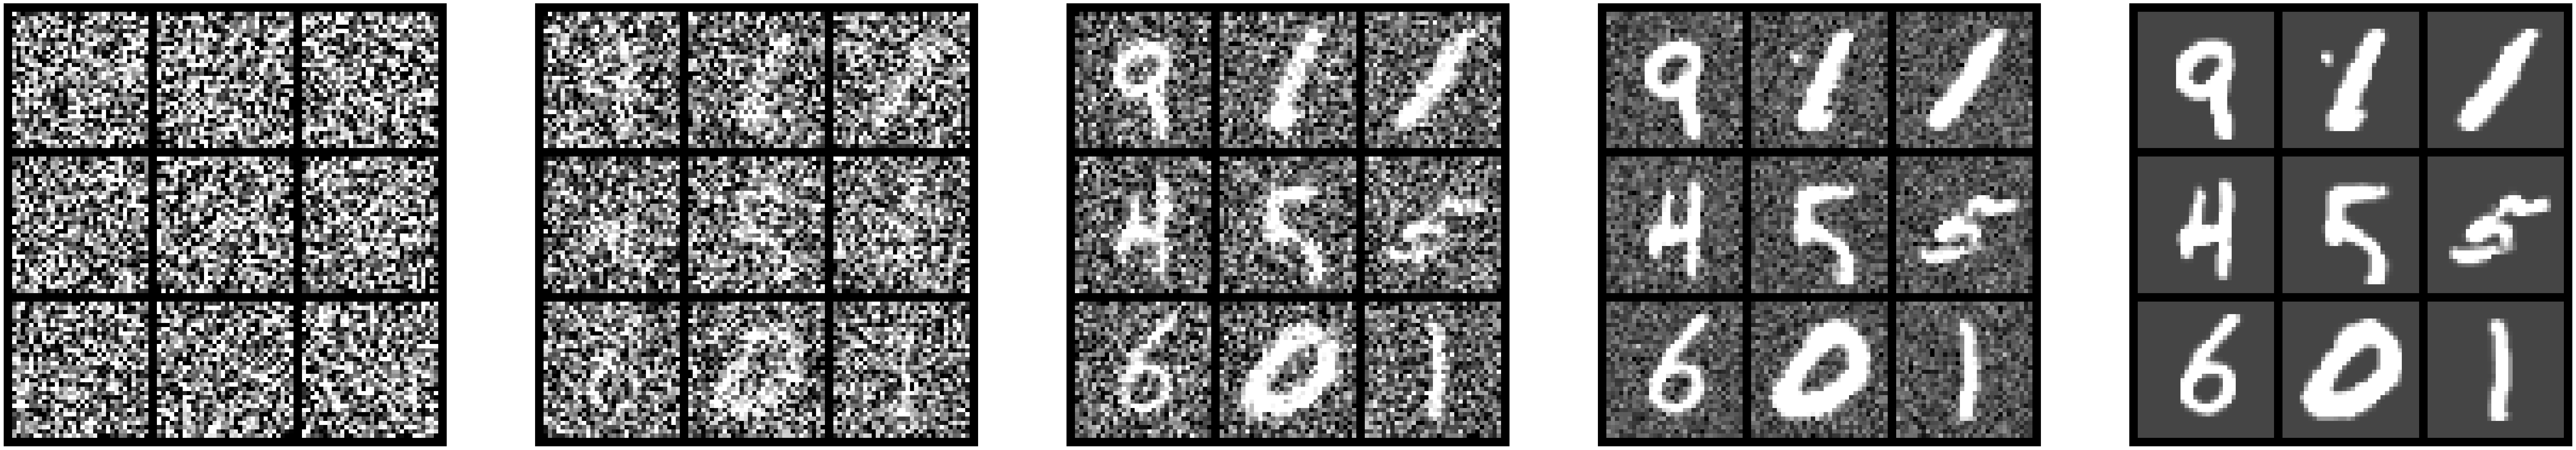

In [ ]:
# Change these!
num_rows = 3
num_cols = 3
num_timesteps = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize our sampler
sampler = MNISTSampler().to(device)

# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Sample
num_samples = num_rows * num_cols
z, _ = path.p_data.sample(num_samples)
z = z.view(-1, 1, 32, 32)

# Setup plot
fig, axes = plt.subplots(1, num_timesteps, figsize=(6 * num_cols * num_timesteps, 6 * num_rows))

# Sample from conditional probability paths and graph
ts = torch.linspace(0, 1, num_timesteps).to(device)
for tidx, t in enumerate(ts):
    tt = t.expand(num_samples) # b
    xt = path.sample_conditional_path(z, tt) # b 1 32 32
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
    axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[tidx].axis("off")
plt.show()

# Part 2: Classifier Free Guidance

**Guidance**: Whereas for unconditional generation, we simply wanted to generate *any* digit, we would now like to be able to specify, or *condition*, on the identity of the digit we would like to generate. That is, we would like to be able to say "generate an image of the digit 8", rather than just "generate an image of a digit". We will henceforth refer to the digit we would like to generate as $x \in \mathbb{R}^{1 \times 32 \times 32}$, and the conditioning variable (in this case, a label), as $y \in \{0, 1, \dots, 9\}$. If we imagine fixing our choice of $y$, and take our data distribution as $p_{\text{simple}}(x|y)$, then we have recovered the unconditional generative problem, and we can construct a generative model using e.g., a conditional flow matching objective via $$\begin{align*}\mathcal{L}_{\text{CFM}}^{\text{guided}}(\theta;y) &= \,\,\mathbb{E}_{\square} \lVert u_t^{\theta}(x|y) - u_t^{\text{ref}}(x|z)\rVert^2\\ \square &= z \sim p_{\text{data}}(z|y), x \sim p_t(x|z)\end{align*}$$
We may now then allow $y$ to vary by simply taking our conditional flow matching expectation to be over $y$ as well (rather than fixing $y$), and explicitly conditioning our learned approximation on $u_t^{\theta}(x|y)$ on the choice of $y$. We therefore obtain the the *guided* conditional flow matching objective $$\begin{align*}\mathcal{L}_{\text{CFM}}(\theta) &= \,\,\mathbb{E}_{\square} \lVert u_t^{\theta}(x|y) - u_t^{\text{ref}}(x|z)\rVert^2\\ \square &= z,y \sim p_{\text{data}}(z,y), x \sim p_t(x|z)\end{align*}$$
Note that $(z,y) \sim p_{\text{simple}}(z,y)$ is obtained in practice by sampling an image $z$, and a label $y$, from our labelled (MNIST) dataset. This is all well and good, and we emphasize that if our goal was simply to sample from $p_{\text{data}}(x|y)$, our job would be done (at least in theory). In practice, one might argue that we care more about the *perceptual quality* of our images. To this end, we will a derive a procedure known as *classifier-free guidance*.

**Classifier-Free Guidance**: For the sake of intuition, we will develop guidance through the lense of Gaussian probability paths, although the final result might reasonably be applied to any probability path. Recall from the lecture that for $(a_t, b_t) = \left(\frac{\dot{\alpha}_t}{\alpha_t}, -\frac{\dot{\beta}_t \beta_t \alpha_t - \dot{\alpha}_t \beta_t^2}{\alpha_t}\right)$, we have $$u_t(x|y) = a_tx + b_t\nabla \log p_t(x|y).$$
This identity allows us to relate the *conditional marginal velocity* $u_t(x|y)$ to the *conditional score* $\nabla \log p_t(x|y)$. However, notice that $$\nabla \log p_t(x|y) = \nabla \log \left(\frac{p_t(x)p_t(y|x)}{p_t(y)}\right) = \nabla \log p_t(x) + \nabla \log p_t(y|x),$$
so that we may rewrite $$u_t(x|y) = a_tx + b_t(\nabla \log p_t(x) + \nabla \log p_t(y|x)) = u_t(x) + b_t \nabla \log p_t(y|x).$$
An approximation of the term $\nabla \log p_t(y|x)$ could be considered as a sort of noisy classifier (and in fact this is the origin of *classifier guidance*, which we do not consider here). In practice, people have noticed that the conditioning seems to work better when we scale the contribution of this classifier term, yielding
$$\tilde{u}_t(x|y) = u_t(x) + w b_t \nabla \log p_t(y|x)$$
where $w > 1$ is known as the *guidance scale*. We may then plug in $b_t\log p_t(y|x) = u^{\text{target}}_t(x|y) - u^{\text{target}}_t(x)$ to obtain $$\begin{align}\tilde{u}_t(x|y) &= u_t(x) + w b_t \nabla \log p_t(y|x)\\
&= u_t(x) + w (u^{\text{target}}_t(x|y) - u^{\text{target}}_t(x))\\
&= (1-w) u_t(x) + w u_t(x|y). \end{align}$$
The idea is thus to train both $u_t(x)$ as well as the conditional model $u_t(x|y)$, and then combine them *at inference time* to obtain $\tilde{u}_t(x|y)$. Our recipe will thus be:
1. Train $u_t^{\theta} \approx u_t(x)$ as well as the conditional model $u_t^{\theta}(x|y) \approx u_t(x|y)$ using conditional flow matching.
2. At inference time, sample using $\tilde{u}_t^{\theta}(x|y)$.

"But wait!", you say, "why must we train two models?". Indeed, we can instead treat $u_t(x)$ as $u_t(x|y)$, where $y=\varnothing$ denotes *the absence of conditioning*. We may thus augment our label set with a new, additional $\varnothing$ label, so that $y \in \{0,1,\dots, 9, \varnothing\}$. This technique is known as **classifier-free guidance** (CFG). We thus arrive at
$$\boxed{\tilde{u}_t(x|y) = (1-w) u_t(x|\varnothing) + w u_t(x|y)}.$$

**Training and CFG**: We must now amend our conditional flow matching objective to account for the possibility of $y = \varnothing$. Of course, when we sample $(z,y)$ from MNIST, we will never obtain $y = \varnothing$, so we must introduce the possibliity of this artificially. To do so, we will define some hyperparameter $\eta$ to be the *probability* that we discard the original label $y$, and replace it with $\varnothing$. In practice, we might set $\varnothing = 10$, for example, as it is sufficient to distinguish it from the other digit identities. When we go and implement our model, we need ony be able to index into some embedding, such as via `torch.nn.Embedding`. We thus arrive at our CFG conditional flow matching training objective:
$$\begin{align*}\mathcal{L}_{\text{CFM}}(\theta) &= \,\,\mathbb{E}_{\square} \lVert u_t^{\theta}(x|y) - u_t^{\text{ref}}(x|z)\rVert^2\\
\square &= z,y \sim p_{\text{data}}(z,y), x \sim p_t(x|z),\,\text{replace $y$ with $\varnothing$ with probability $\eta$}\end{align*}$$
In plain English, this objective reads:
1. Sample an image $z$ and a label $y$ from $p_{\text{data}}$ (here, MNIST).
2. With probability $\eta$, replace the label $y$ with the null label $\varnothing \triangleq 10$.
3. Sample $t$ from $\mathcal{U}[0,1]$.
4. Sample $x$ from the conditional probability path $p_t(x|z)$.
5. Regress $u_t^{\theta}(x|y)$ against $u_t^{\text{ref}}(x|z)$.


### Question 2.2: Training for Classifier-Free Guidance
In this section, you'll the training objective $\mathcal{L}_{\text{CFM}}(\theta)$ in which $u_t^{\theta}(x|y)$ is an instance of the class `ConditionalVectorField` described below.

In [ ]:
class ConditionalVectorField(nn.Module, ABC):
    """
    Conditional vector field u_t^theta(x|y)
    """

    @abstractmethod
    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
        """
        Args:
        - x: b ...
        - t: b
        - y: b
        Returns:
        - u_t^theta(x|y): b ...
        """
        pass

class CFGVectorFieldODE(ODE):
    def __init__(self, net: ConditionalVectorField, null_label: int, guidance_scale: float = 1.0):
        self.net = net
        self.guidance_scale = guidance_scale
        self.null_label = null_label

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - x: b ...
        - t: b
        - y: b
        """
        guided_vector_field = self.net(x, t, y)
        unguided_y = torch.ones_like(y) * self.null_label
        unguided_vector_field = self.net(x, t, unguided_y)
        return (1 - self.guidance_scale) * unguided_vector_field + self.guidance_scale * guided_vector_field


**Your job**: Fill in `CFGFlowTrainer.get_train_loss`, so that it implements $\mathcal{L}_{\text{CFM}}(\theta)$ described above. In doing so, feel free to "hardcode" $\varnothing = 10$. A more general implementation would not make this MNIST-specific assumption, but for the sake of this assignment you may do so. We recommend completing Question 2.2 and Question 2.3 together, as their combination can be tested in Sanity Check 2.4.

**Hints**:
1. To sample an image $(z,y) \sim p_{\text{data}}$, use `self.path.p_data.sample`
2. You can generate a mask corresponding to "probability $\eta$" via `mask = torch.rand(batch_size) < self.eta`.
3. You can sample $t \sim \mathcal{U}[0,1]$ using `torch.rand(batch_size, 1, 1, 1)`. Don't mix up `torch.rand` with `torch.randn`!
4. You can sample $x \sim p_t(x|z)$ using `self.path.sample_conditional_path`.

In [ ]:
class CFGTrainer(Trainer):
    def __init__(self, path: GaussianConditionalProbabilityPath, eta: float, null_label: int, eps: float = 0.001, **kwargs):
        assert eta > 0 and eta < 1
        super().__init__(**kwargs)
        self.eta = eta
        self.eps = eps
        self.path = path
        self.null_label = null_label

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        # Step 1: Sample z,y from p_data
        z, y = self.path.p_data.sample(batch_size)

        # Step 2: Set each label to 10 (i.e., null) with probability eta
        mask = torch.rand(batch_size, device = y.device) < self.eta
        y = y.clone()
        y[mask] = self.null_label

        # Step 3: Sample t and x
        t = torch.rand(batch_size, device = z.device)
        # t = t*(1-2*self.eps) + self.eps
        x = self.path.sample_conditional_path(z, t)

        # Step 4: Regress and output loss
        # pass
        return torch.mean(torch.square( self.model(x,t,y) - self.path.conditional_vector_field(x, z, t)))

        # raise NotImplementedError("Implement me in Question 2.2!")

To sanity check our implementation of `CFGTrainer`, we'll train a simple MLP-based model to sample conditionally from a Gaussian mixture. First, let's implement the class `MLPConditionalVectorField`.

### Question 2.3: MLPConditionalVectorField
**Your job:** Implement `MLPConditionalVectorField.forward`.

In [ ]:
# Sanity check: implement MLPConditionalVectorField

class MLP(nn.Module):
  def __init__(self, dims: List[int], activation: Type[torch.nn.Module] = torch.nn.SiLU):
    super().__init__()
    mlp = []
    for idx in range(len(dims) - 1):
        mlp.append(torch.nn.Linear(dims[idx], dims[idx + 1]))
        if idx < len(dims) - 2:
            mlp.append(activation())
    self.net = torch.nn.Sequential(*mlp)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """
    Args:
    - x: b n d
    Returns:
    - x: b n d
    """
    return self.net(x)

class MLPConditionalVectorField(ConditionalVectorField):
  def __init__(
      self,
      dim: int,
      hidden_dim: int,
      class_dim: int,
      num_classes: int
    ):
    super().__init__()
    self.mlp = MLP([dim + class_dim + 1, hidden_dim, hidden_dim, dim])
    self.class_embedding = nn.Embedding(num_classes + 1,class_dim)

  def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor):
      """
      Args:
      - x: b d
      - t: b
      - y: b
      Returns:
      - u_t^theta(x|y): (b, c, h, w)
      """
      y_emb = self.class_embedding(y) # (b, class_dim)
      t = t.view(-1,1) # (b,1)

      # raise NotImplementedError("Implement me in Question 2.3!")
      return self.mlp(torch.cat((x, t, y_emb), dim=-1))

### Sanity Check 2.4
Finally, let's check our work in Questions 2.2 and 2.3 by combining `CFGTrainer`, `CFGVectorFieldODE`, and `MLPConditionalVectorField` to sample from a Gaussian mixture (`GMM`) instance.



Initialized output directory at: runs/hidden-plum-ac0bd75d
Training model with size: 0.259 MiB


Step 2999, lr=1.00e-03, loss=0.5772: 100%|██████████| 3000/3000 [00:13<00:00, 225.97it/s]


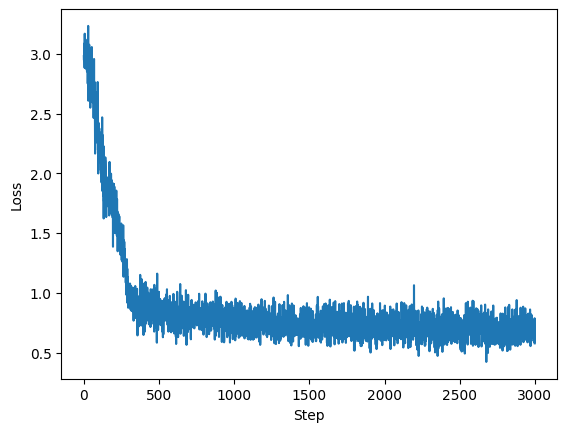

In [ ]:
#######################################################################
# Train MLP-based Conditional Vector Field to target Gaussian mixture #
#######################################################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize GMM
angles = [0, 2 * math.pi / 3, 4 * math.pi / 3]
means = 2 * torch.tensor([[math.cos(a), math.sin(a)] for a in angles])
covs = torch.tensor([0.2, 0.2, 0.2])
weights = torch.tensor([1/3, 1/3, 1/3])
gmm = GMM(means, covs, weights).to(device)

# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data = gmm,
    p_simple_shape = [2],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)
vector_field = MLPConditionalVectorField(
    dim = 2,
    hidden_dim = 256,
    class_dim = 2,
    num_classes = 3
).to(device)

# Train vector field
trainer = CFGTrainer(
    path=path,
    eta=0.25,
    null_label=3,
)
losses, steps = trainer.train(model=vector_field, num_steps=3000, lr=1e-3, batch_size=250)
plt.plot(steps, losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

100%|██████████| 99/99 [00:00<00:00, 1834.32it/s]


Text(0.5, 1.0, 'Unguided Samples')

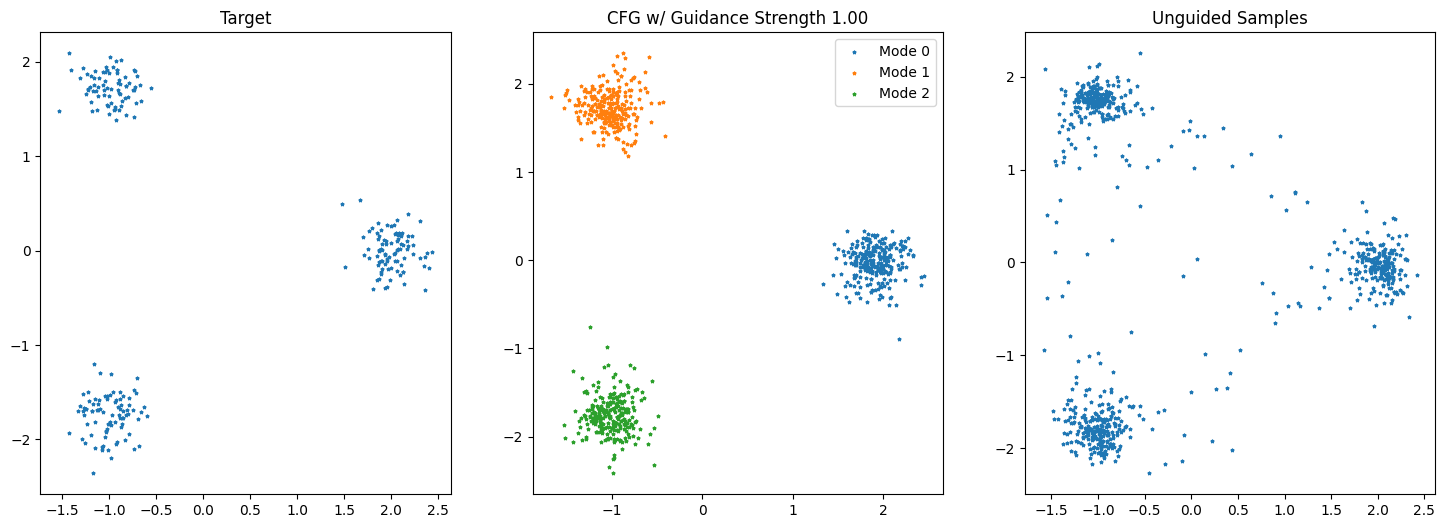

In [ ]:
#####################
# Visualize Results #
#####################

# User knobs
guidance_strength = 1.0 # try changing me!

fig, axes = plt.subplots(1, 3, figsize=(6 * 3, 6))

# Panel 1: Target
ax = axes[0]
x_data, _ = gmm.sample(250)
x_data = x_data.detach().cpu().numpy()
ax.scatter(x_data[:, 0], x_data[:, 1], s=5, marker="*")
ax.set_title("Target")

# Panel 2: Conditioned on each mode
ax = axes[1]
cfg_vector_field = CFGVectorFieldODE(vector_field, guidance_scale=guidance_strength, null_label=3)
simulator = EulerSimulator(cfg_vector_field)

batch_size = 250
labels = torch.arange(3).repeat_interleave(batch_size).to(device)
x_init = path.p_simple.sample(3 * batch_size) # b 2
ts = torch.linspace(0, 1, 100).expand(3 * batch_size, -1).to(device) # b nt
xs = simulator.simulate(x_init, ts, y=labels) # b 2
for idx in range(3):
    xs_idx = xs[idx * batch_size: (idx + 1) * batch_size].detach().cpu().numpy()
    ax.scatter(xs_idx[:, 0], xs_idx[:, 1], s=5, label=f"Mode {idx}", marker="*")
ax.legend()
ax.set_title(f"CFG w/ Guidance Strength {guidance_strength:.2f}")

# Panel 3: Unconditioned
ax = axes[2]
batch_size = 750
labels = torch.ones(batch_size).long().to(device) * 3
x_init = path.p_simple.sample(batch_size) # b 2
ts = torch.linspace(0, 1, 100).expand(batch_size, -1).to(device) # b nt
xs = simulator.simulate(x_init, ts, y=labels).detach().cpu().numpy() # b 2
ax.scatter(xs[:, 0], xs[:, 1], s=5, label=f"Mode {idx}", marker="*")
ax.set_title(f"Unguided Samples")

# Part 3: Building a Diffusion Transformer
At this point, we have discussed classifier free guidance, and the necessary considerations that must be made on the part of our model and in training our model. What remains is to actually discuss the choice of model. In particular, our usual choice of an MLP, while fine for the simple distributions of the previous lab, will no longer suffice. To this end, we will implement a **diffusion transformer** component-by-component!

### Question 3.1: Fourier Time Encoder

First, we implement a *Fourier time encoder*, which maps a scalar time value $t \in [0,1]$ to
$$
    t^{\text{emb}} = \begin{bmatrix}
    \cos(2\pi w_1 t) & \cdots & \cos(2\pi w_d t) & \sin(2\pi w_1 t) & \cdots & \sin(2\pi w_d t)
    \end{bmatrix}^T,
$$
where the weights $w_i \sim \mathcal{N}(0, 1)$ are drawn from a unit normal.

**Your job**: Implement `FourierEncoder`.

In [ ]:
class FourierEncoder(nn.Module):
    """
    Based on https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/karras_unet.py#L183
    """
    def __init__(self, dim: int):
        super().__init__()
        assert dim % 2 == 0
        half_dim = dim // 2

        # 1. Initialize self.weights
        # self.w_i = torch.randn(1, half_dim)
        self.register_buffer("w_i", torch.randn(1, half_dim))

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
        - t: b
        Returns:
        - embeddings: b d
        """
        # Step 1: compute frequencies f_i = 2 * pi * w_i * t
        f_i = 2 * torch.pi * self.w_i * t[:,None]

        # Step 2: compute sin(f_i) and cos(f_i)
        t_emb_cos, t_emb_sin = torch.cos(f_i), torch.sin(f_i)

        # Step 3: Concatenate and return
        return torch.cat((t_emb_cos,t_emb_sin), dim=-1)

        # raise NotImplementedError("Implement me in Question 3.1!")

### Question 3.2: Patchifier

The patchifier takes in an image-valued tensor of shape `b 1 32 32`, and *patchifies* it to shape `b (h / p * w / p) d`, where `d` denotes the diffusion transformer hidden dimension, `p` denotes the patch size, and `h` and `w` denote the image height and width, respectively. It does this in two steps:
1. Applies a convolutional layer mapping the an input of shape `b 1 32 32` to `b d h/p h/w`.
2. Rearranges from `b d h/p h/w` to `b (h/p h/w) d` (i.e., `n = h/p * h/w` tokens with dimension `d`).

**Your job:** Implement `Patchifier`.

In [ ]:
class Patchifier(nn.Module):
  def __init__(self, img_size: int, patch_size: int, dim: int):
    super().__init__()
    assert img_size % patch_size == 0, "Image size must be divisible by patch size"

    # 1. Initialize whatever you need to initialize!
    self.conv = nn.Conv2d(in_channels=1, out_channels = dim, kernel_size = patch_size, stride = patch_size, bias = True)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """
    Args:
    - x: (bs, 1, img_size, img_size)
    Returns:
    - x: (bs, 1, img_size, img_size)
    """
    # 2. Do whatver you need to do with whatever you initialized!
    x = self.conv(x)  # (bs, dim, h/p, w/p)
    x = rearrange(x, 'b d h w -> b (h w) d')  # (bs, h/p*w/p, dim)

    return x
    # raise NotImplementedError("Implement me in Question 3.2!")

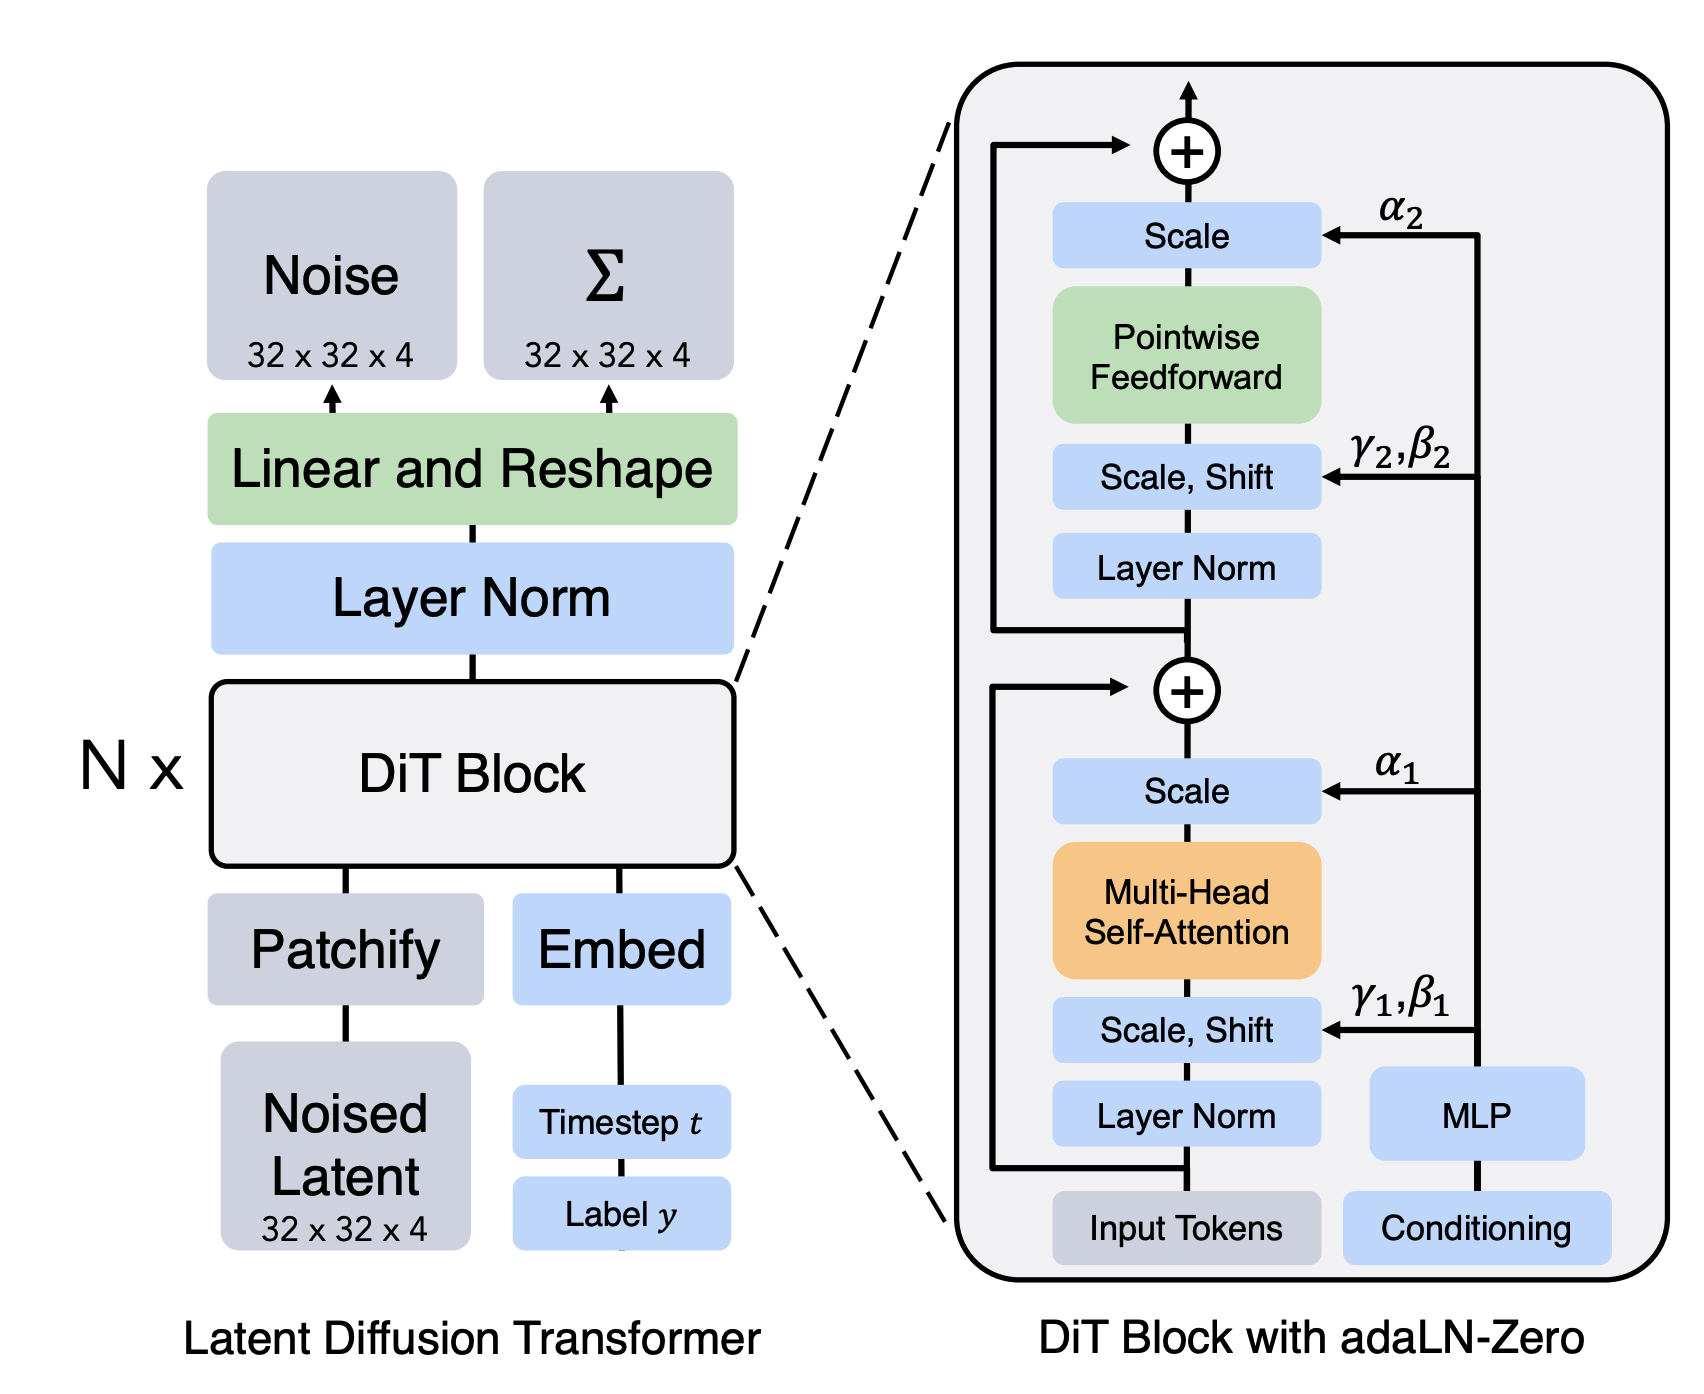

### Question 3.3: Diffusion Transformer
Our data is now in the shape `b n d`, where `n` denotes the number of image tokens per image. We'll now pass it through a transformer. In the spirit of banging your head against a wall, you'll be implementing the whole thing! In particular, implementing attention from scratch is an incredibly valuable exercise if you haven't done so already. As you work through this question, feel free to consult the diffusion transformer arcihtectural diagram above, taken from [1].


**Your job**: finish `MHA` (multi-headed self-attention), `DiffusionTransformerLayer`, and `DiffusionTransformer`.

**Recommended steps**: Let's work our way down.
1. First, implement `DiffusionTransformer`. In particular, we recommend learning fixed per-position encodings using e.g., `nn.Parameter(torch.randn(n_tokens, dim))`. Note that you have access to the (fixed) number of tokens via the argument `n_tokens`. Additionally, you'll need to initialize `depth` instances of `DiffusionTransformerLayer`. Then, a forward pass simply involves adding your positional encodings to your input (be careful about broadcasting!), and passing through the diffusion transformer layers.
2. Second, implement `DiffusionTransformerLayer`. For this we refer to the diagram above. Note that adaLN-Zero refers to zero-initializing the conditioning MLP weights (the last layer will suffice). While this is optional, zero-initializing these residual connections often helps to stablize training. We note that $\gamma, \beta, \alpha$ should have shape `b d` (be careful about broadcasting), and that the scale and shift operation is usually implemented as the modulation $x \mapsto x * (1 + \gamma) + \beta$. For the feed-forward network, feel free to use the previously defined `MLP` class. A typical choice in DiT's is to use hidden dimensions `[dim, 4 * dim, dim]`.
3. Finally, implemented multi-headed self-attention. For this, the internet is your friend :)

We highly recommend not using a ChatGPT, Gemini, Claude, or any other large language model to write this code for you. This lab is optional and you'd only be robbing yourself of a carefully curated opportunity to get your hands dirty and do some machine learning!

In [ ]:
class MHA(nn.Module):
  """
  Multi-headed self-attention
  """
  def __init__(self, dim: int, heads: int):
    super().__init__()
    assert dim % heads == 0

    self.w_q = nn.Linear(dim,dim)
    self.w_k = nn.Linear(dim,dim)
    self.w_v = nn.Linear(dim,dim)
    self.dim = dim
    self.heads = heads
    self.scale = (dim // heads) ** -0.5
    self.dropout = nn.Dropout(0.025)

    self.linear = nn.Linear(dim,dim)

    # raise NotImplementedError("Implement me in Question 3.3!")

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """
    Args:
    - x: b n d
    Returns:
    - x: b n d
    """
    # 1. Compute queries, keys, and values
    q = self.w_q(x)      # (b n d)
    k = self.w_k(x)      # (b n d)
    v = self.w_v(x)      # (b n d)

    # 2. Fold head into batch dimension
    q = rearrange(q, 'b n (h k) -> b h n k', h = self.heads)
    k = rearrange(k, 'b n (h k) -> b h n k', h = self.heads)
    v = rearrange(v, 'b n (h k) -> b h n k', h = self.heads)

    # 3. Compute attention
    attn_wt = torch.softmax(q @ k.transpose(-2,-1) * self.scale, dim=-1 )

    # 4. Combine with values
    attn = attn_wt @ v     # 'b h n n' x 'b h n k' = 'b h n k'

    # 5. Unfold heads
    attn = rearrange(attn, 'b h n k -> b n (h k)')

    # 6. Pass throuh FF and return
    x = self.linear(attn)
    x = self.dropout(x)

    return x
    # raise NotImplementedError("Implement me in Question 3.3!")

class DiffusionTransformerLayer(nn.Module):
  def __init__(
      self,
      dim: int,
      heads: int,
  ):
    """
    Args:
    - n_tokens: sequence length (for sake of positional embeddings)
    - dim: dimension of hidden layers
    - heads: number of attention heads
    """
    super().__init__()
    dff = dim * 4
    self.mha = MHA(dim, heads)
    self.conditioningMLP = nn.Linear(dim,6*dim)
    nn.init.zeros_(self.conditioningMLP.weight)
    nn.init.zeros_(self.conditioningMLP.bias)

    self.ffn1 = nn.Linear(dim,dff)
    self.dropout = nn.Dropout(0.025)
    self.gelu = nn.GELU()
    self.ffn2 = nn.Linear(dff,dim)

    self.layer_normc1 = nn.LayerNorm(dim, elementwise_affine = False)
    self.layer_normc2 = nn.LayerNorm(dim, elementwise_affine = False)

    # Initialize whatever you need here!
    # raise NotImplementedError("Implement me in Question 3.3!")

  def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
    """
    Args:
    - x: b n d
    - c: b d
    Returns:
    - x: b n d
    """
    # 1. Compute conditioning gating, scaling, and bias
    cparams = self.conditioningMLP(c)                          # (b, 6d)
    cparams = rearrange(cparams, 'b (k d) -> b k d', k=6)      # (b, 6, d)
    cparams = cparams.unsqueeze(2)
    gamma1, beta1, alpha1, gamma2, beta2, alpha2 = cparams.unbind(dim=1)

    # 2. Attention + FF

    y = self.layer_normc1(x)
    y = y * (1 + gamma1) + beta1
    y = self.mha(y)
    x = x + y * alpha1

    y = self.layer_normc2(x)
    y = y * (1 + gamma2) + beta2
    y = self.ffn2(self.dropout(self.gelu(self.ffn1(y))))
    x = x + y * alpha2

    return x
    # raise NotImplementedError("Implement me in Question 3.3!")


class DiffusionTransformer(nn.Module):
  def __init__(
      self,
      depth: int,
      n_tokens: int,
      dim: int,
      **layer_kwargs,
  ):
    """
    Args:
    - n_tokens: sequence length (for sake of positional embeddings)
    - dim: dimension of hidden layers
    - heads: number of attention heads
    - depth: number of layers
    """
    super().__init__()
    self.depth = depth
    self.n_tokens = n_tokens
    self.dim = dim
    self.layers = nn.ModuleList([DiffusionTransformerLayer(dim= dim, **layer_kwargs) for _ in range(depth)])
    self.pos_emb = nn.Parameter(torch.randn(n_tokens, dim))

    # Initialize DiT layers + positional encodings
    # raise NotImplementedError("Implement me in Question 3.3!")


  def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
    """
    Args:
    - x: b n d
    - c: b d
    Returns:
    - x: b n d
    """
    # 1. Add encodings to x
    x  = x + self.pos_emb.unsqueeze(0)

    # 2. Pass through DiT layers
    for layer in self.layers:
      x = layer(x, c)

    return x

    # raise NotImplementedError("Implement me in Question 3.3!")


### Question 3.4 Depatchifier
After the diffusion transformer, we need to convert from `b n d` back to `b 1 h w`.

**Your job:** Implement `Depatchifier`.

**Hints**: One approach would be to
1. Start with some sort of normalization. `nn.LayerNorm` or `nn.RMSNorm` wil suffice.
2. Pass through some MLP to obtain `b (h/p w/p) (f p p)` (ie, map to dimension $d=fp^2$, for patch size $p$ and "final dimension" $f$.
3. Rearrange to `b f h w`.
4. Pass through final convolution to obtain output of shape `b 1 h w`.

In [ ]:
class Depatchifier(nn.Module):
  def __init__(self, img_size: int, patch_size: int, dim: int, final_dim: int = 10):
      super().__init__()
      self.patch_size = patch_size
      assert img_size % patch_size == 0, "Image size must be divisible by patch size"
      h = w = img_size // patch_size
      self.img_size = img_size
      self.h = h
      self.w = w
      self.final_dim = final_dim

      self.layernorm = nn.LayerNorm(dim, elementwise_affine = True)
      self.linear = nn.Linear(dim, final_dim * self.patch_size * self.patch_size)
      self.conv2d = nn.Conv2d(in_channels = final_dim, out_channels = 1, kernel_size = 1, stride = 1)

      # Initialize whatever you need here
      # raise NotImplementedError("Implement me in Question 3.4!")

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      """
      Args:
      - x: b n d
      Returns:
      - x: b 1 32 32
      """

      x = self.layernorm(x)
      x = self.linear(x)
      x = rearrange(x, 'b (h w) (f p1 p2) -> b f (h p1) (w p2)', h= self.h, w = self.w, p1 = self.patch_size, p2 = self.patch_size, f = self.final_dim)
      x = self.conv2d(x)

      return x
      # Do whatever you need to do with whatever you initialized here!
      # raise NotImplementedError("Implement me in Question 3.4!")


### Question 3.5: Putting It All Together
Finally, let's implement our DiT-based guided flow model $u_t^\theta(x|y)$ with the class `MNISTDiffusionTransformer`.

**Your job**: Implement `MNISTDiffusionTransformer`.

**Hint**:
1. To embed the guiding input `y`, you'll need class labels. You can reuse your solution from `MLPConditionalVectorField`. In particular, we recommend using `nn.Embedding(num_classes=11, embedding_dim=dim)`. Note we use 11 - not 10 - classes to account for the presence of the null label.
2. Follow the DiT overview diagram: embed $t$ and $y$, add them together to obtain the guiding variable. Pass $x$ through the patchifier, and then pass the patchifier output and $t + y$ through the diffusion transformer. Finally, pass the DiT output through the depatchifier.

In [ ]:
class MNISTDiffusionTransformer(ConditionalVectorField):
  def __init__(
      self,
      patch_size: int = 8,
      num_layers: int = 12,
      dim: int = 256,
      heads: int = 4,
    ):
      super().__init__()

      self.image_size = 32
      # 0. Construct time_embedder and y_embedder
      self.fourierEncoder = FourierEncoder(dim)

      self.y_embedder = nn.Embedding(num_embeddings = 11, embedding_dim = dim)

      # 1. Construct patchifier
      self.patchifier = Patchifier(img_size = self.image_size, patch_size=patch_size, dim=dim)

      # 2. Construct DiT
      self.diffusionTransformer = DiffusionTransformer(depth = num_layers, n_tokens = (self.image_size//patch_size)*(self.image_size//patch_size), dim=dim, heads = heads)

      # 3. Construct de-patchifier
      self.depatchifier = Depatchifier(img_size = self.image_size, patch_size=patch_size, dim=dim)

      # raise NotImplementedError("Implement me in Question 3.5!")


  def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Args:
    - x: b 1 32 32
    - t: b 1 1 1
    - c: b 1 1 1
    Returns:
    - u_t^theta(x|y): b 1 32 32
    """
    # 1. Embed time and y
    b = x.shape[0]
    t_emb = self.fourierEncoder(t.reshape(b))
    y_flat = y.reshape(b).long()
    y_emb = self.y_embedder(y_flat)
    c = t_emb + y_emb

    # 2. Patchify
    x = self.patchifier(x)

    # 3. Pass through DiT
    ut = self.diffusionTransformer(x, c)

    # 4. Depatchify
    ut = self.depatchifier(ut)

    return ut
    # raise NotImplementedError("Implement me in Question 3.3!")

### Training the Diffusion Transformer

In [ ]:
##################
# Training utils #
##################

def visualize_output(model, path, samples_per_class: int = 10, num_timesteps: int = 100, guidance_scales: List[float] = [1.0, 3.0, 5.0], save_path: Optional[str] = None, use_tqdm: bool = True):
  # Graph
  fig, axes = plt.subplots(1, len(guidance_scales), figsize=(10 * len(guidance_scales), 10))

  for idx, w in enumerate(guidance_scales):
      # Setup ode and simulator
      ode = CFGVectorFieldODE(model, guidance_scale=w, null_label=10)
      simulator = EulerSimulator(ode)

      # Sample initial conditions
      y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.int64).repeat_interleave(samples_per_class).to(device)
      num_samples = y.shape[0]
      x0 = path.p_simple.sample(num_samples) # (num_samples, 1, 32, 32)

      # Simulate
      ts = torch.linspace(0,0.999,num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
      x1 = simulator.simulate(x0, ts, y=y, use_tqdm=use_tqdm)

      # Plot
      v_min, v_max = x1.min(), x1.max()
      x1 = (x1 - v_min) / (v_max - v_min)
      grid = make_grid(x1, nrow=samples_per_class, normalize=True, value_range=(0,1))
      axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
      axes[idx].axis("off")
      axes[idx].set_title(f"Guidance: $w={w:.1f}$", fontsize=25)

  # Save
  if save_path is not None:
      plt.savefig(save_path)
      plt.close()
  else:
    plt.show()

class MNISTCFGTrainer(CFGTrainer):
  '''
  CFG Trainer with MNIST-specific callback
  '''
  def checkpoint(self, step: int):
    # Save model
    torch.save(self.model.state_dict(), os.path.join(self.output_dir, f'step_{step:6d}_model.pt'))
    torch.save(self.opt.state_dict(), os.path.join(self.output_dir, f'step_{step:6d}_opt.pt'))

    # Save output visualization
    visualize_output(self.model, self.path, save_path=os.path.join(self.output_dir, f'step_{step:6d}_output.png'), use_tqdm=False)

Now let's finally train our model! Note that you can track the progress of your model during training by looking at intermediate outback and visualizations within the indicated run directory!

Initialized output directory at: runs/misty-pear-59d57b27
Training model with size: 36.366 MiB


Step 19999, lr=4.00e-04, loss=0.1962: 100%|██████████| 20000/20000 [1:22:27<00:00,  4.04it/s]


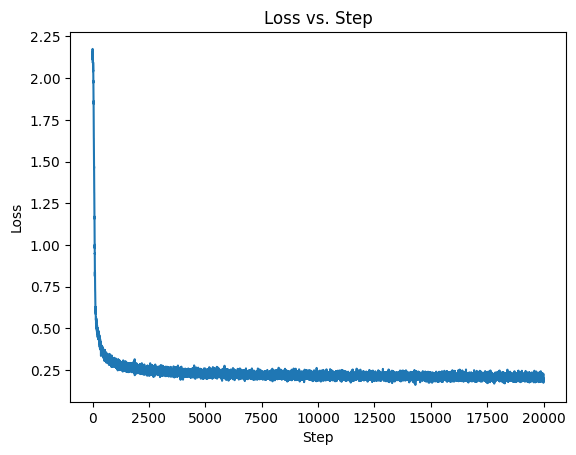

In [ ]:
#################
# Training code #
#################

# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Initialize model
dit = MNISTDiffusionTransformer(
    patch_size = 4,
    num_layers = 8,
    dim = 256,
    heads = 8,
).to(device)

# Initialize trainer
trainer = MNISTCFGTrainer(path = path, eta=0.35, null_label=10)

# Train! You should have reasonable results in ~15 A100 minutes
losses, steps = trainer.train(model=dit, num_steps = 20000, lr=0.4e-3, batch_size=256, ckpt_every=1000)

plt.plot(steps, losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss vs. Step")
plt.show()

Let's view the output of our final model!

100%|██████████| 99/99 [00:04<00:00, 20.61it/s]


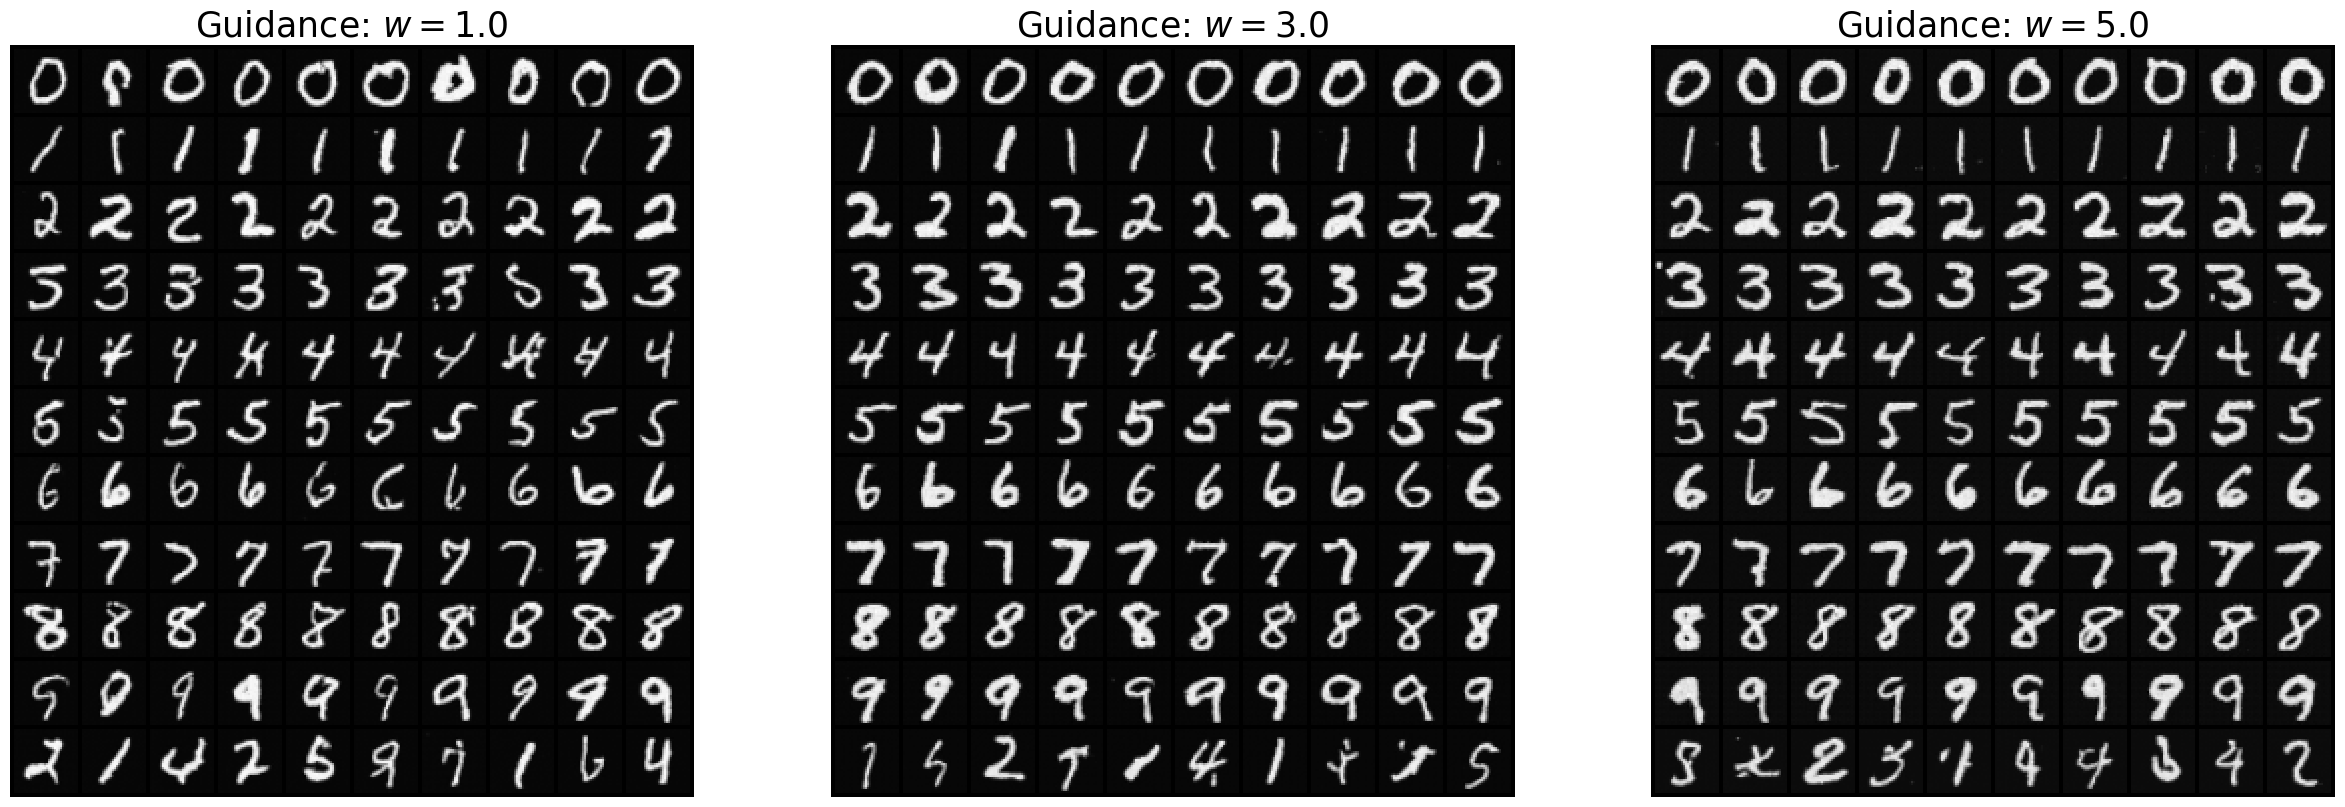

In [ ]:
# Play with these!
samples_per_class = 10
num_timesteps = 100
guidance_scales = [1.0, 3.0, 5.0]

visualize_output(
    model=dit,
    path=path,
    samples_per_class=samples_per_class,
    num_timesteps=num_timesteps,
    guidance_scales=guidance_scales,
)
plt.show()

### References:
1. William Peebles and Saining Xie. Scalable Diffusion Models with Transformers. 2023. arXiv: 2212 . 09748
[cs.CV]. url: https://arxiv.org/abs/2212.09748.
